# Pipeline & base model

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Load data

In [2]:
df = pd.read_csv('data/f_chtr_churn_traintable_nf_2.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209043 entries, 0 to 209042
Columns: 170 entries, auftrag_new_id to date_x
dtypes: float64(32), int64(120), object(18)
memory usage: 271.1+ MB


## Check

In [3]:
null_rel = round(df.isin([0]).sum() / df.shape[0]*100,2)
null_rel = null_rel.to_frame()
null_rel.rename(columns={0: "null %"}, inplace=True)

In [4]:
eda.meta(df).T.join(null_rel).head()

,nulls,percent,dtype,dup,nuniques,null %
varname,,,,,,
kuendigungs_eingangs_datum,142754,68.29,object,True,349,0.00
ort,85,0.04,object,True,11475,0.00
email_am_kunden,12,0.01,float64,True,2,6.43
auftrag_new_id,0,0,object,False,209043,0.00
openrate_produktnews_1w,0,0,float64,True,10,98.43


In [5]:
print(f"shape {df.shape}")
continues = df.select_dtypes(include=['float64','int64'])
print(f"numeric features {len(continues.columns)}")
categorial = df.select_dtypes(include="object")
print(f"object features   {len(categorial.columns)}")

shape (209043, 170)
numeric features 152
object features   18


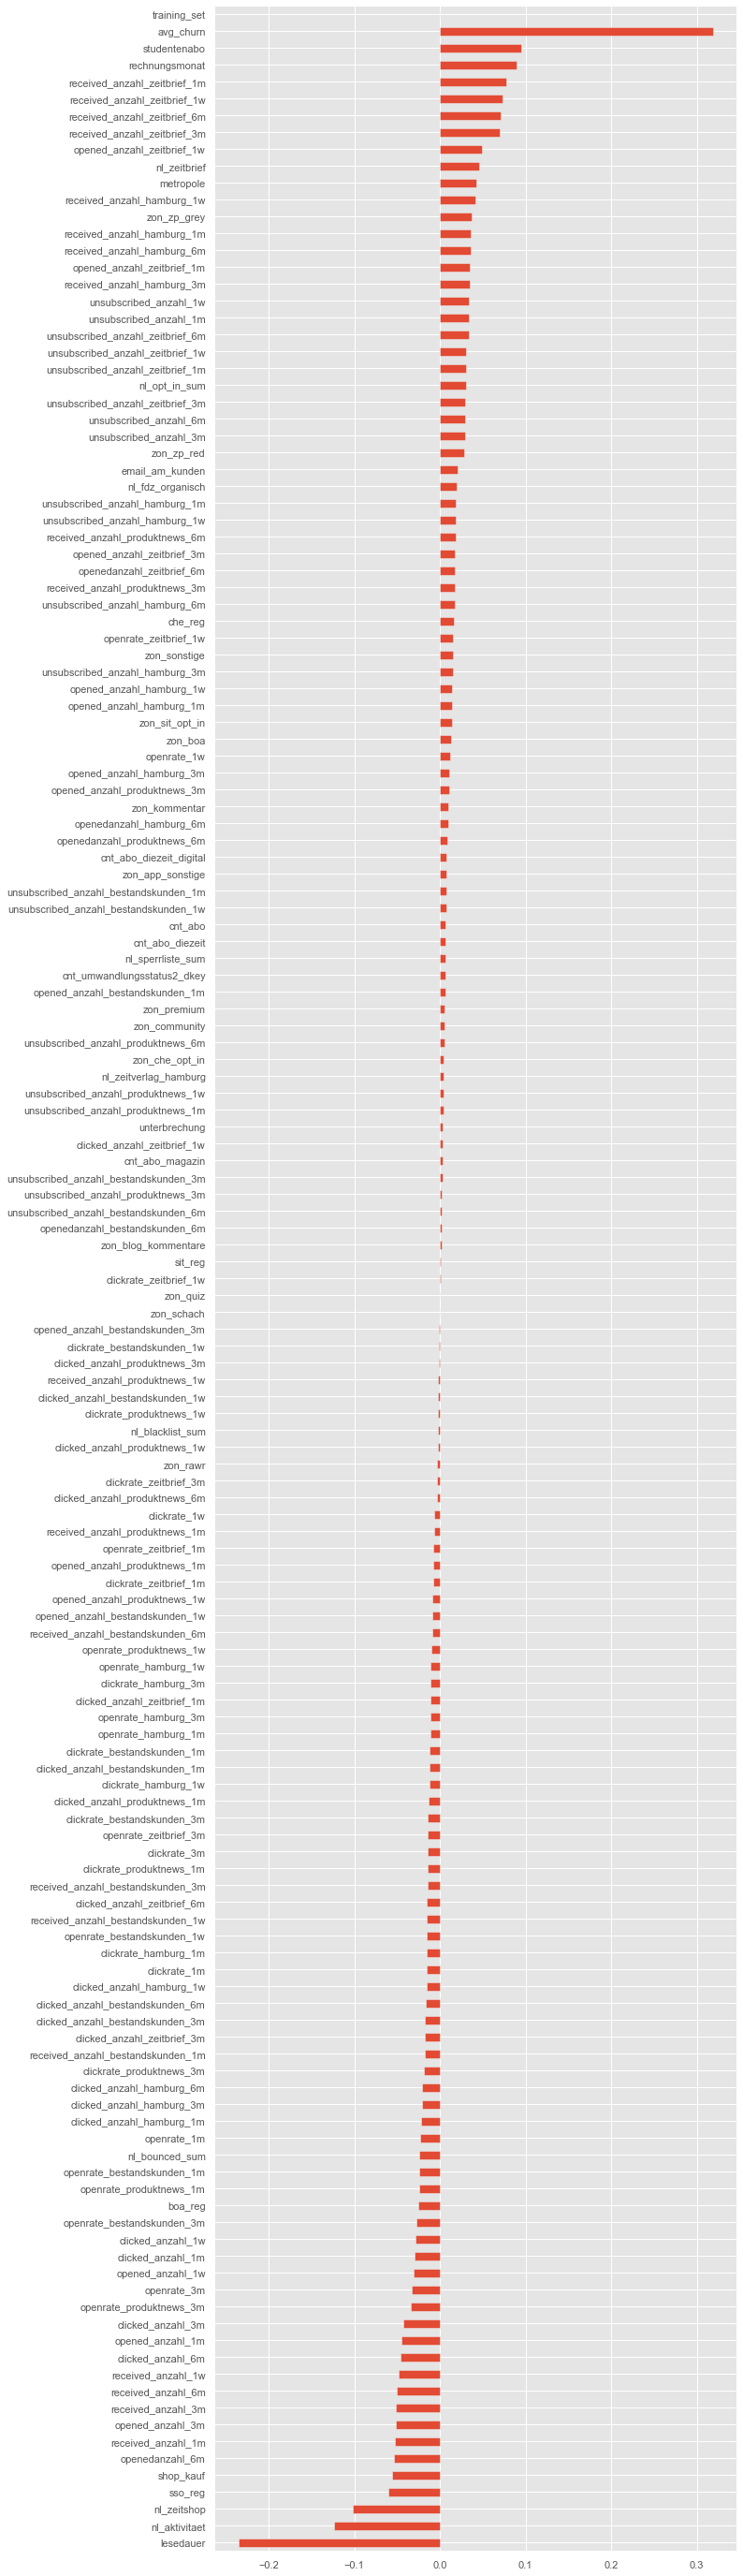

In [6]:
df.drop('churn', axis=1).corrwith(df.churn).sort_values().plot(kind='barh',figsize=(10, 50));

## Drop features

In [7]:
print(df.shape)
df.drop(["auftrag_new_id", "avg_churn", "ort", "date_x", "kuendigungs_eingangs_datum", "abo_registrierung_min"], axis=1, inplace=True)
print(df.shape)

(209043, 170)
(209043, 164)


## Sample & split

In [8]:
# calculate sample size for 1% and 10%
one_percent = df.sample(int(round(len(df) / 100)))
ten_percent = df.sample(int(round(len(df) / 10)))
print(one_percent.shape)
print(ten_percent.shape)
ten_percent.head()

(2090, 164)
(20904, 164)


,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,...,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,churn
175434,2019-05-01,Mailings,ZEIT Digital,Negative Option,jährlich,12,1,Rechnung,0,2,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
6384,2014-10-01,Telefonmarketing,DIE ZEIT,Festabo,jährlich,59,0,Bankeinzug,0,3,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
208615,2019-02-27,Telefonmarketing,ZEIT Digital,Festabo,vierteljährlich,6,0,Bankeinzug,0,9,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0
176962,2019-01-17,Fremdwerbung,DIE ZEIT,Negative Option,jährlich,11,0,Rechnung,0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
158904,2019-02-27,andere,ZEIT Digital,Negative Option,halbjährlich,5,0,Rechnung,0,7,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [9]:
y = ten_percent['churn']
X = ten_percent.drop('churn', axis = 1)
X.shape

(20904, 163)

## Pipeline

In [10]:
# enhancements:
# - save predictions by clf to var
# - print colorful reports
# - save predictions to dataframe to compare

def pipeline(X,y):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])
    categoric_features

    numeric_features = list(X.columns[X.dtypes != object])
    numeric_features

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    eda.plot_train_test_split(y,y_train,y_test)

    # defining the models
    models = [
        LogisticRegression,
        KNeighborsClassifier,
        SVC,
        DecisionTreeClassifier,
        RandomForestClassifier, 
        XGBClassifier,
        AdaBoostClassifier
    ]

    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])


    # process pipeline for every model
    for model in models:
        print('\n'+str(model))
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', model())
                               ])

        # fit model
        pipe.fit(X_train, y_train)  

        #predict results
        y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
        y_test_pred = pipe.predict(X_test)

        # print results
        print("\nResults on training data: ")
        print(classification_report(y_train, y_train_pred))
        print("\nResults on test data:")
        print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")

# Results

Training set has 15678 samples.
Testing set has 5226 samples.
Training set has 15678 samples.
Testing set has 5226 samples.

<class 'sklearn.linear_model._logistic.LogisticRegression'>

Results on training data: 
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     10667
           1       0.57      0.43      0.49      5011

    accuracy                           0.71     15678
   macro avg       0.66      0.64      0.64     15678
weighted avg       0.70      0.71      0.70     15678


Results on test data:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81      3559
           1       0.58      0.44      0.50      1667

    accuracy                           0.72      5226
   macro avg       0.67      0.65      0.65      5226
weighted avg       0.71      0.72      0.71      5226


Confusion matrix on test
[[3032  527]
 [ 932  735]]



<class 'sklearn.neighbors._classification.KNeighborsCl

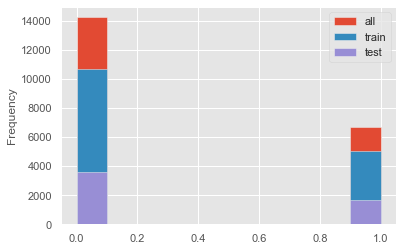

In [11]:
# 10 percent data
pipeline(X,y)